In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import Adam
import numpy as np
import keras 

# Loading Model and Cascade Classifier

In [4]:
car_classifier = cv2.CascadeClassifier("haarcascade_car.xml")
nameplate_classifier= cv2.CascadeClassifier("indian_license_plate.xml")
character_recognizer = load_model('Numeric_Character_Recognition.h5')

# Extracting Nameplate from the Car Image 

In [5]:
def nameplate_extractor(image):
    frame = image.copy()
    #Converting image from BGR to GRAY
    nameplates = []
    #Load classifier for nameplate detection
    nameplate_classifier= cv2.CascadeClassifier("indian_license_plate.xml")
    detected_nameplates = nameplate_classifier.detectMultiScale(frame, scaleFactor=1.3, minNeighbors=7)
    #Rescaling Image
    y_scale, x_scale = (int(0.020*frame.shape[0]),int(0.012*frame.shape[1]))
    for x,y,w,h in detected_nameplates:
        nameplates.append(image[y+y_scale:y+h, x+x_scale:x+w])  
        cv2.rectangle(frame, (x,y), (x+w,y+h), color=(0,255,0), thickness=2)
    
    return nameplates, frame

# Finding Largest Contours --> Characters

In [6]:
def findContours(image, validDimensions):
    #Converting grayscale image to binary image
    binary_img = image.copy()

    #Identifing contours and considering the largest 15 countours for character recognition
    contours, hierarchy = cv2.findContours(binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:20]
    
    y_lower, y_upper, x_lower,x_upper = validDimensions
    start_indices = []
    cntr_width = []
    character_images = []
    
    for contour in contours:
        x,y,width,height = cv2.boundingRect(contour)

        #Check if width and height of character is in valid character dimensions
        if width>y_lower and width < y_upper and height > x_lower and height < x_upper:
            
            cv2.rectangle(binary_img, (x,y),(x+width,y+height), color=(204), thickness=2)
            #Adding start of each character 
            start_indices.append(x)
            cntr_width.append(width)
            charImg = image[y-2:y+height+2,x-2:x+width+2]
            charImg = cv2.resize(charImg,(26,46))
            charImg_ = ~(charImg)
            charImg_ = np.ones((50,30))
            charImg_[2:48,2:28] = charImg
            charImg_[0:2,:] = 0
            charImg_[:,0:2] = 0
            charImg_[-3:,:] = 0
            charImg_[:,-3:] = 0
            
            
            #Appending all the character images. Note characters are not in order
            character_images.append(charImg_)        
    #Storing image with detected characters
    cv2.imwrite("DetectedCharacters.jpg",binary_img)
    
    #Sort the characters based on start indices i.e x --> gives correct order of characters from L2R
    character_sorted = []
    cntr_width_sorted = []
    start_indices_sorted = []
    indices = sorted(range(len(start_indices)), key= lambda i: start_indices[i])[:15]
    for i in indices:
        character_sorted.append(character_images[i])
        cntr_width_sorted.append(cntr_width[i])
        start_indices_sorted.append(start_indices[i])
    
    
    #Checking for contours between same [x:x+width] 
    #Removing smaller contour image which comes under same bounding rectangle
    start = 0
    image_result = []
    
    for i,ch in enumerate(character_sorted):
        
        if start_indices_sorted[i] >= start:
            image_result.append(ch)
            start = start_indices_sorted[i]+cntr_width_sorted[i]-10
        
    image_result = np.array(image_result)
    return image_result
    


In [7]:
def imageSegementation(images):
    character_list_final = []
    for image in images:
        character_list_final = []
        img = image.copy()
        img = cv2.resize(img,(320,80))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        threshold, image_binary = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        image_binary = cv2.erode(image_binary,(3,3))
        image_binary = cv2.dilate(image_binary,(3,3))
        width, height = image_binary.shape[0], image_binary.shape[1]
        #Taking estimated character size for determining useful contours
        character_dimentions = (int(width/8), int(width/2), int(height/10), int(9*height/10))
        #Colouring border
        image_binary[0:3,:] = 0
        image_binary[:,0:3] = 0
        image_binary[-3:,:] = 0
        image_binary[:,-3:] = 0
        character_list_final = findContours(image_binary, character_dimentions)
        print(len(character_list_final))
        
        
    return character_list_final
    
    
    

# Recognizing Characters using CNN

In [8]:
#LABELS --> dictionary for classes recognized by model
LABELS = {}
for i in range(0,10):
    LABELS[i] = str(i)
for i in range(65,91):
    LABELS[i-55] = chr(i)

#Fixing the dimension of image as required by model here model takes image of dimension (30,30,3) 
def fix_dimension(img): 
    new_img = np.zeros((30,30,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img


def recognizeCharacters(charactersList):
    plate_number = ""
    
    for i,ch in enumerate(charactersList):
        ch_ = cv2.resize(ch, (30,30))
        ch_final = fix_dimension(ch_)
        ch_final = ch_final.reshape(1,30,30,3)
        #predicted_class = character_recognizer.predict_classes(ch_final)
        predicted_class = np.argmax(character_recognizer.predict(ch_final), axis=-1)
        plate_number += LABELS[predicted_class[0]]
    return plate_number       

10
1/1 [==============================] - 0s 23ms/step


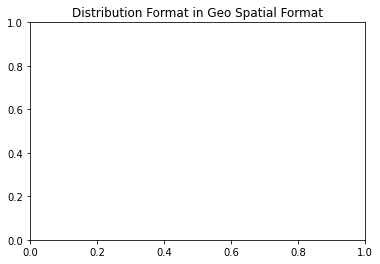

In [9]:

frame = cv2.imread("cars.jpeg")


plate, image = nameplate_extractor(frame)

plt.title("Distribution Format in Geo Spatial Format")

character_list_final = imageSegementation(plate)
plate_num = recognizeCharacters(character_list_final)



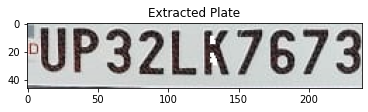

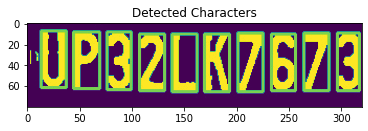

In [10]:
plt.imshow(plate[0])
plt.title("Extracted Plate")
plt.show()

plt.imshow(plt.imread("DetectedCharacters.jpg"))
plt.title("Detected Characters")
plt.show()

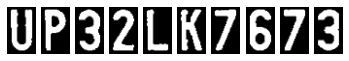

In [11]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(character_list_final[i], cmap='gray')
    plt.axis('off')

In [12]:
print(f'PLATE NUMBER : {plate_num}')


PLATE NUMBER : UP32LK7673
